In [2]:
%pip install pm4py

     ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
     -- ------------------------------------- 0.1/1.8 MB 2.4 MB/s eta 0:00:01
     --------- ------------------------------ 0.4/1.8 MB 5.3 MB/s eta 0:00:01
     ----------- ---------------------------- 0.5/1.8 MB 3.6 MB/s eta 0:00:01
     ------------ --------------------------- 0.6/1.8 MB 3.2 MB/s eta 0:00:01
     ------------ --------------------------- 0.6/1.8 MB 3.2 MB/s eta 0:00:01
     ------------------------ --------------- 1.1/1.8 MB 3.8 MB/s eta 0:00:01
     ---------------------------- ----------- 1.3/1.8 MB 3.9 MB/s eta 0:00:01
     ------------------------------------- -- 1.7/1.8 MB 4.4 MB/s eta 0:00:01
     ---------------------------------------- 1.8/1.8 MB 4.5 MB/s eta 0:00:00
     ---------------------------------------- 0.0/47.0 kB ? eta -:--:--
     ---------------------------------------- 47.0/47.0 kB ? eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:

import pm4py
import pandas as pd
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.importer.xes import importer as xes_importer

# process mining 
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery

# viz
#from pm4py.visualization.petrinet import visualizer as pn_visualizer
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
from pm4py.visualization.dfg import visualizer as dfg_visualization

# misc 
from pm4py.objects.conversion.process_tree import converter as pt_converter

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)



In [17]:
log = xes_importer.apply('BPI_Challenge_2012.xes.gz')

parsing log, completed traces :: 100%|██████████| 13087/13087 [00:22<00:00, 589.96it/s]


In [3]:
## Printing the first trace
log[0]

{'attributes': {'REG_DATE': datetime.datetime(2011, 10, 1, 0, 38, 44, 546000, tzinfo=datetime.timezone(datetime.timedelta(seconds=7200))), 'concept:name': '173688', 'AMOUNT_REQ': '20000'}, 'events': [{'org:resource': '112', 'lifecycle:transition': 'COMPLETE', 'concept:name': 'A_SUBMITTED', 'time:timestamp': datetime.datetime(2011, 10, 1, 0, 38, 44, 546000, tzinfo=datetime.timezone(datetime.timedelta(seconds=7200)))}, '..', {'org:resource': '10629', 'lifecycle:transition': 'COMPLETE', 'concept:name': 'W_Valideren aanvraag', 'time:timestamp': datetime.datetime(2011, 10, 13, 10, 37, 37, 26000, tzinfo=datetime.timezone(datetime.timedelta(seconds=7200)))}]}

In [4]:
log[0][0]  ## printing the first event in first trace

{'org:resource': '112', 'lifecycle:transition': 'COMPLETE', 'concept:name': 'A_SUBMITTED', 'time:timestamp': datetime.datetime(2011, 10, 1, 0, 38, 44, 546000, tzinfo=datetime.timezone(datetime.timedelta(seconds=7200)))}

In [5]:
from pm4py.algo.filtering.log.start_activities import start_activities_filter
from pm4py.algo.filtering.log.end_activities import end_activities_filter

log_start = start_activities_filter.get_start_activities(log)
end_activities = end_activities_filter.get_end_activities(log)
log_start  # Printing the start activity in our log

{'A_SUBMITTED': 13087}

In [6]:
end_activities  # Printing the end activity in our log

{'W_Valideren aanvraag': 2747,
 'W_Wijzigen contractgegevens': 4,
 'A_DECLINED': 3429,
 'W_Completeren aanvraag': 1939,
 'A_CANCELLED': 655,
 'W_Nabellen incomplete dossiers': 452,
 'W_Afhandelen leads': 2234,
 'W_Nabellen offertes': 1290,
 'W_Beoordelen fraude': 57,
 'O_CANCELLED': 279,
 'A_REGISTERED': 1}

A process variant is a unique path from the very beginning to the very end of the process

In [7]:
from pm4py.algo.filtering.log.variants import variants_filter
#from pm4py.statistics.traces.log import case_statistics
variants = variants_filter.get_variants(log)
print(f"We have:{len(variants)} variants in our log")

We have:4366 variants in our log


In [21]:
df = pm4py.convert_to_dataframe(log)

c:\Users\Anjali\AppData\Local\Programs\Python\Python311\Lib\site-packages\pm4py\utils.py:494: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


In [ ]:
case_statistics = df.groupby('case:concept:name').size().reset_index(name='event_count')

In [23]:
print(case_statistics)

      case:concept:name  event_count
0                173688           26
1                173691           39
2                173694           59
3                173697            3
4                173700            3
5                173703            9
6                173706           14
7                173709           12
8                173712           14
9                173715           24
10               173718           77
11               173721           35
12               173724           20
13               173727            3
14               173730           76
15               173733            6
16               173736           55
17               173739           48
18               173742           40
19               173745           19
20               173748           38
21               173751           24
22               173754           42
23               173757            3
24               173760           26
25               173763            6
2

In [ ]:
## Let's try to understand how many cases do those variants have?
from pm4py.algo.filtering.log.variants import variants_filter
#from pm4py.statistics.traces.log import case_statistics
variants = variants_filter.get_variants(log)
print(f"We have:{len(variants)} variants in our log")

variant_counts = {}
for variant in variants:
    variant_str = ' -> '.join([event[0] for event in variant])
    variant_counts[variant_str] = sum([case for case in log if variants_filter.apply(case, variant)])

# Sort and print the top 10 variants by case number
top_variants = sorted(variant_counts.items(), key=lambda x: x[1], reverse=True)[:10]
for variant, count in top_variants:
    print(f"Variant: {variant}, Case Count: {count}")

In [9]:
from pm4py.algo.filtering.log.attributes import attributes_filter
activities = attributes_filter.get_attribute_values(log, "concept:name")
activities

{'A_SUBMITTED': 13087,
 'A_PARTLYSUBMITTED': 13087,
 'A_PREACCEPTED': 7367,
 'W_Completeren aanvraag': 54850,
 'A_ACCEPTED': 5113,
 'O_SELECTED': 7030,
 'A_FINALIZED': 5015,
 'O_CREATED': 7030,
 'O_SENT': 7030,
 'W_Nabellen offertes': 52016,
 'O_SENT_BACK': 3454,
 'W_Valideren aanvraag': 20809,
 'A_REGISTERED': 2246,
 'A_APPROVED': 2246,
 'O_ACCEPTED': 2243,
 'A_ACTIVATED': 2246,
 'O_CANCELLED': 3655,
 'W_Wijzigen contractgegevens': 12,
 'A_DECLINED': 7635,
 'A_CANCELLED': 2807,
 'W_Afhandelen leads': 16566,
 'O_DECLINED': 802,
 'W_Nabellen incomplete dossiers': 25190,
 'W_Beoordelen fraude': 664}

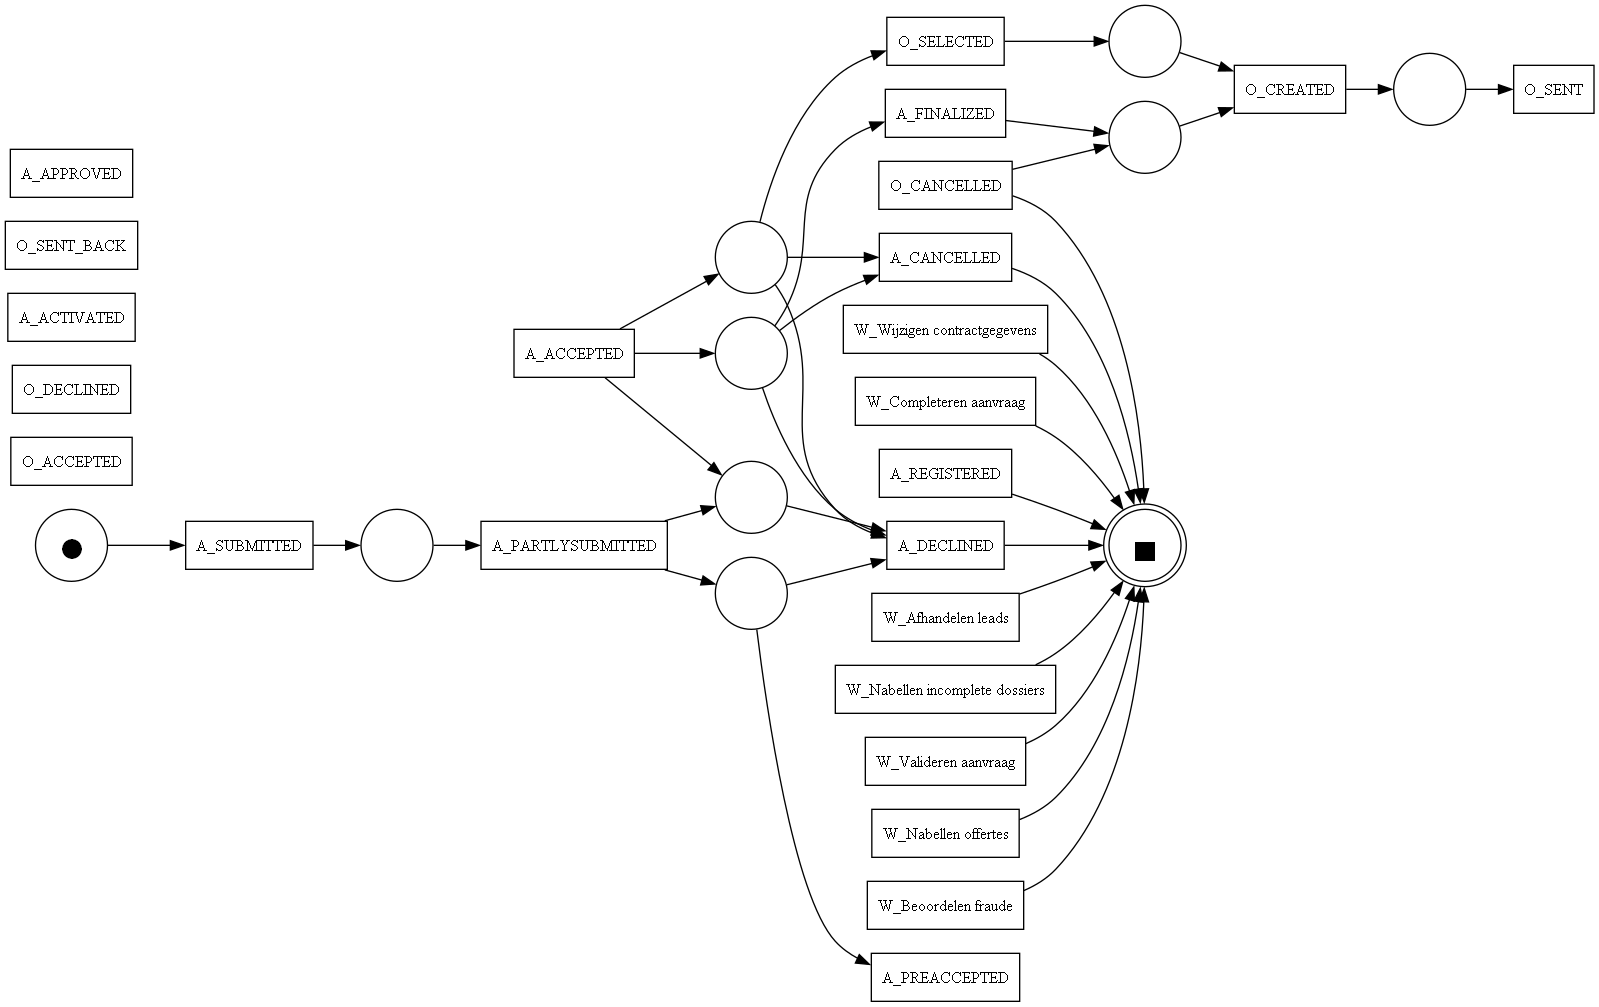

In [10]:
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.visualization.petri_net.util import performance_map 

net, initial_marking, final_marking = alpha_miner.apply(log)
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)

replaying log with TBR, completed variants :: 100%|██████████| 4366/4366 [00:06<00:00, 639.63it/s]


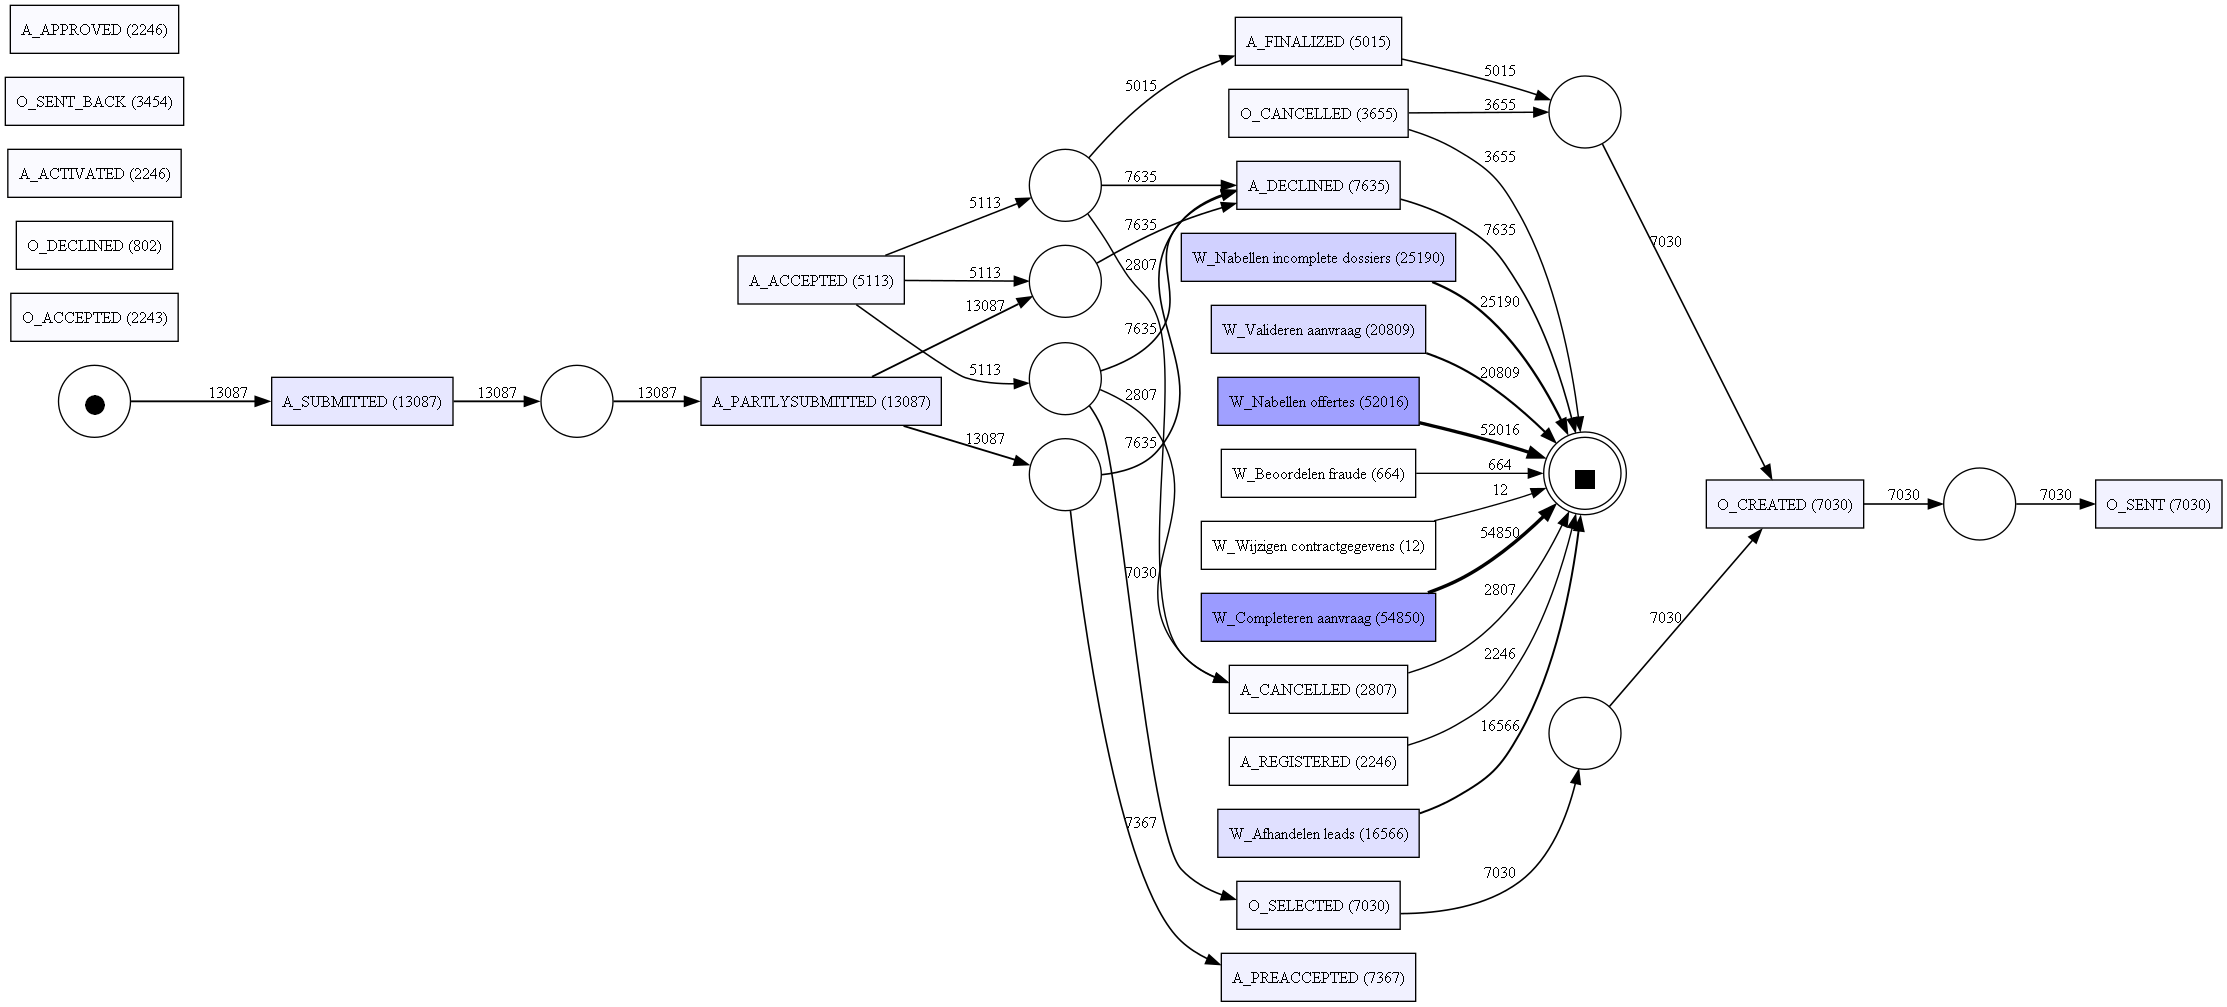

In [11]:
## Adding frequency

parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
gviz = pn_visualizer.apply(net, initial_marking, final_marking, 
                           parameters=parameters,
                           variant=pn_visualizer.Variants.FREQUENCY,
                           log=log)
pn_visualizer.view(gviz)

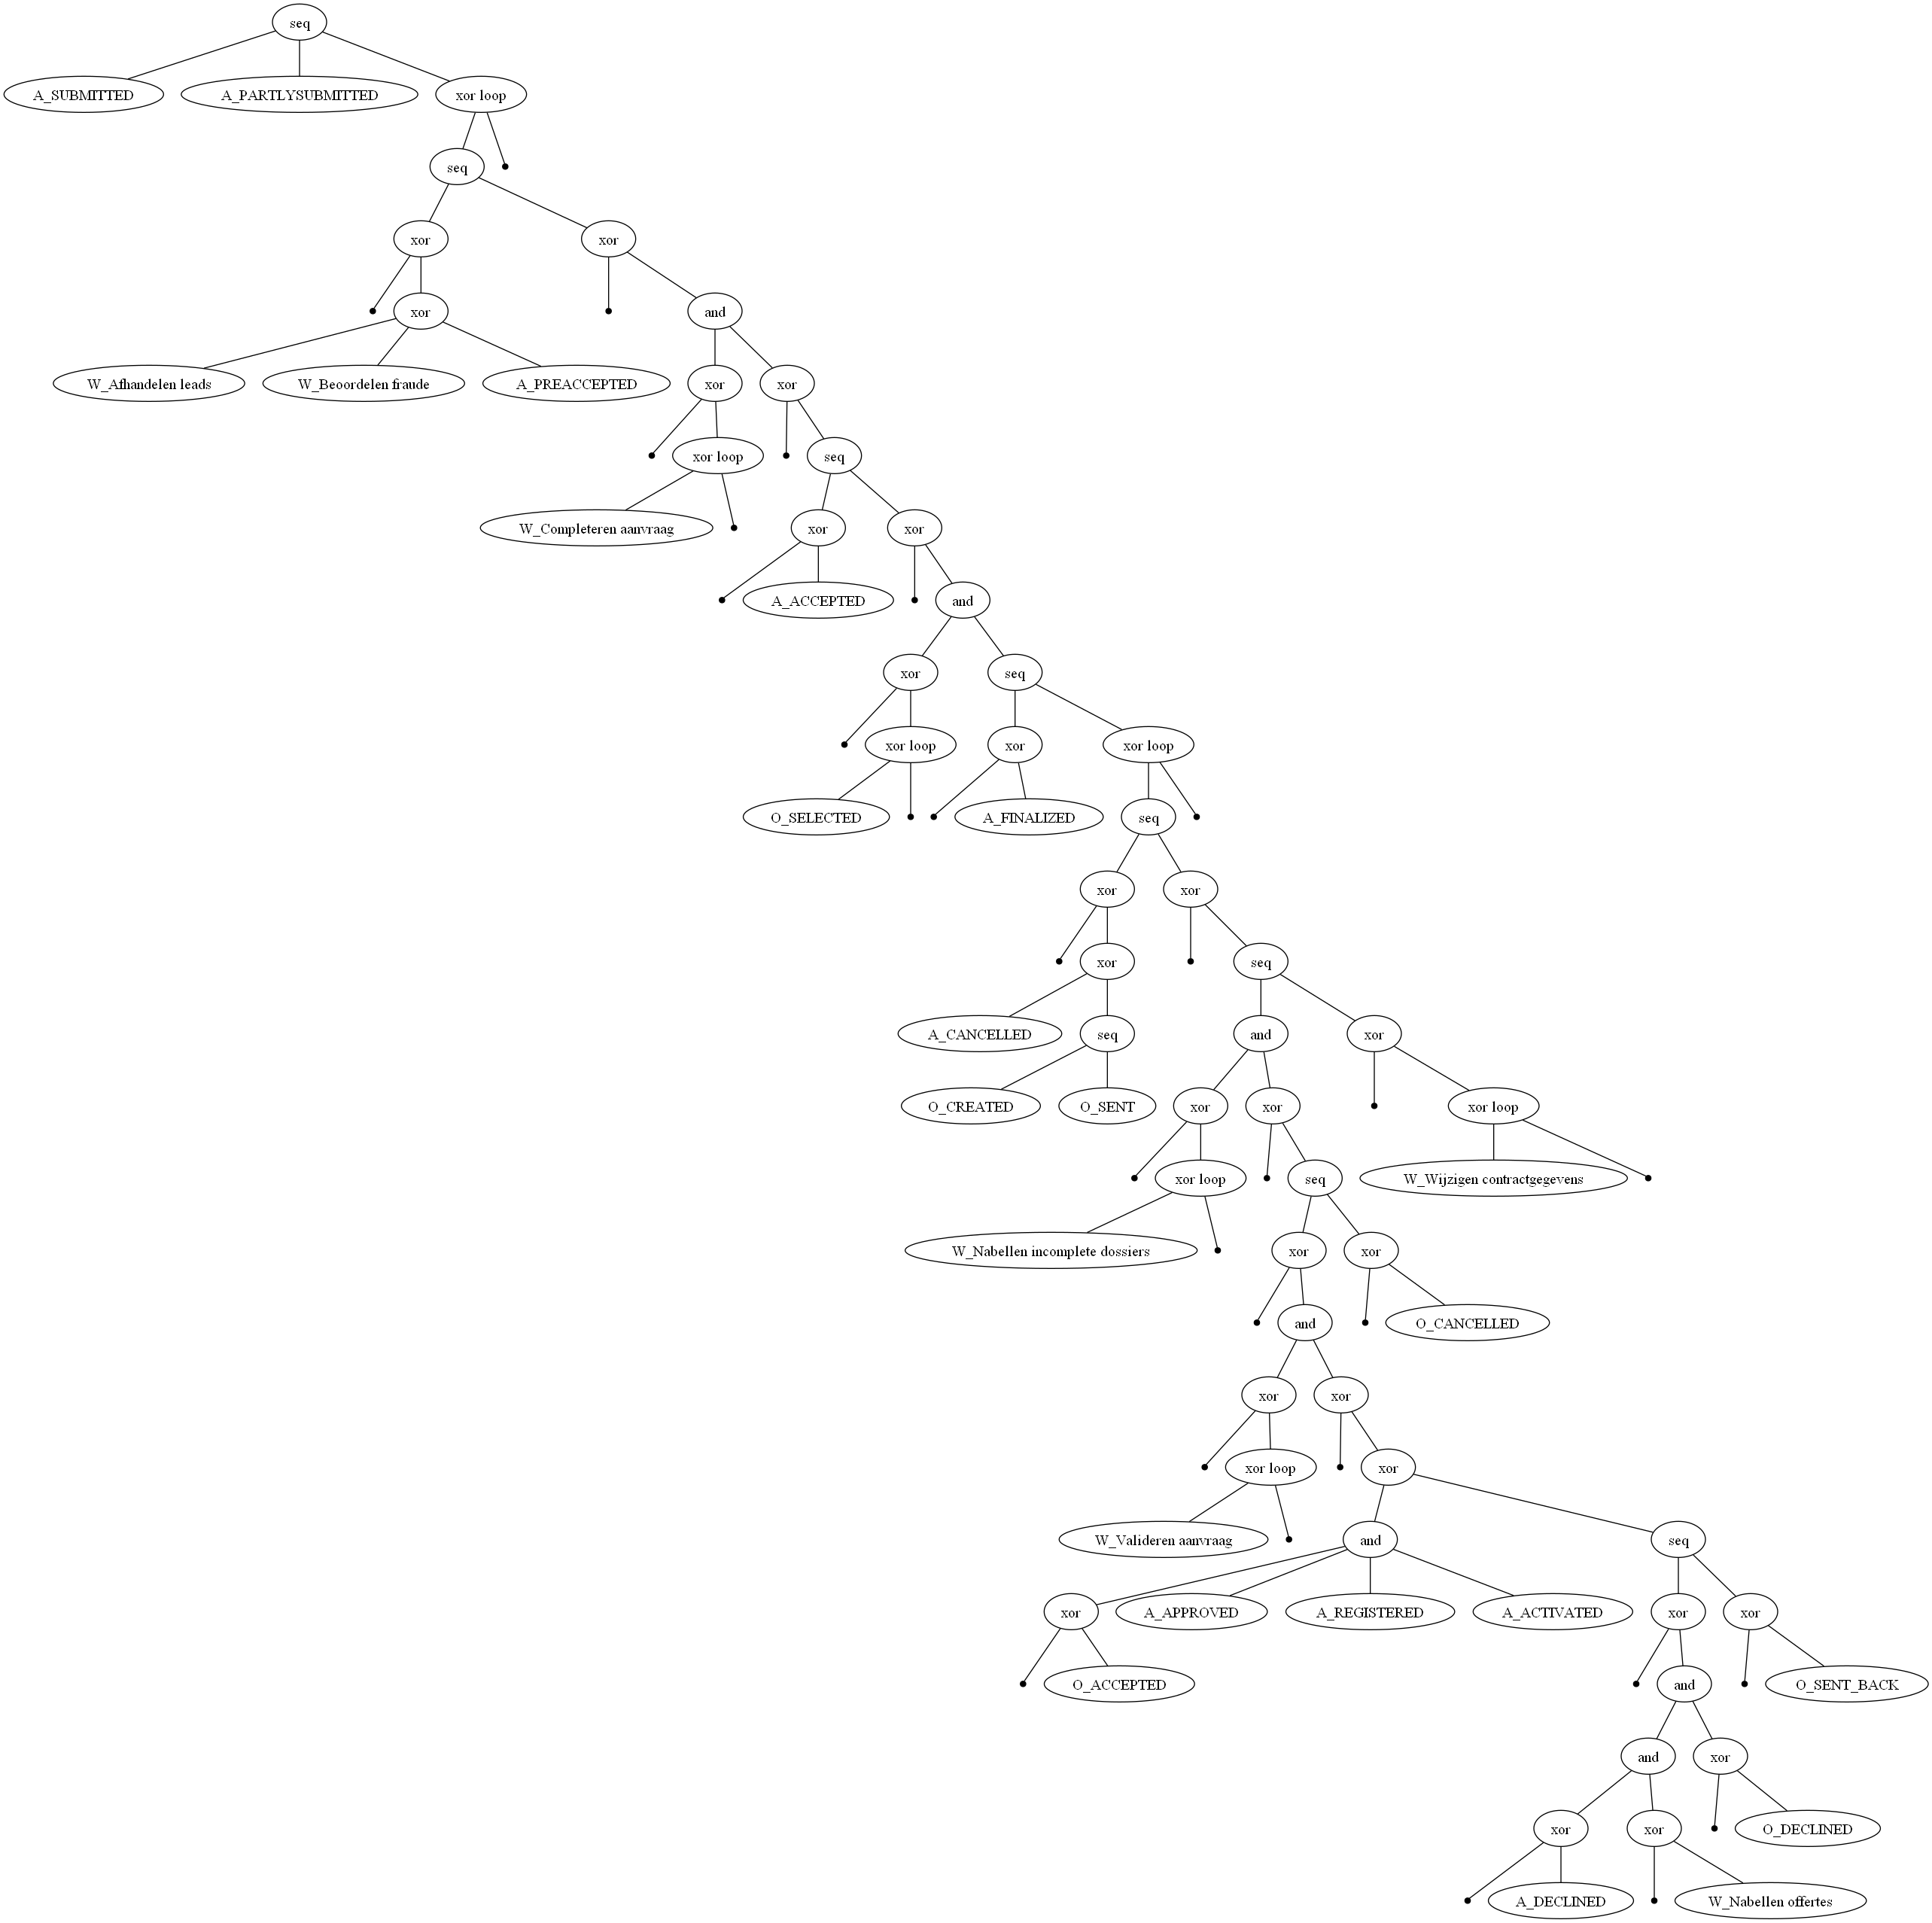

In [13]:
tree = inductive_miner.apply(log)

# Visualize the process tree
gviz = pt_visualizer.apply(tree)
pt_visualizer.view(gviz)


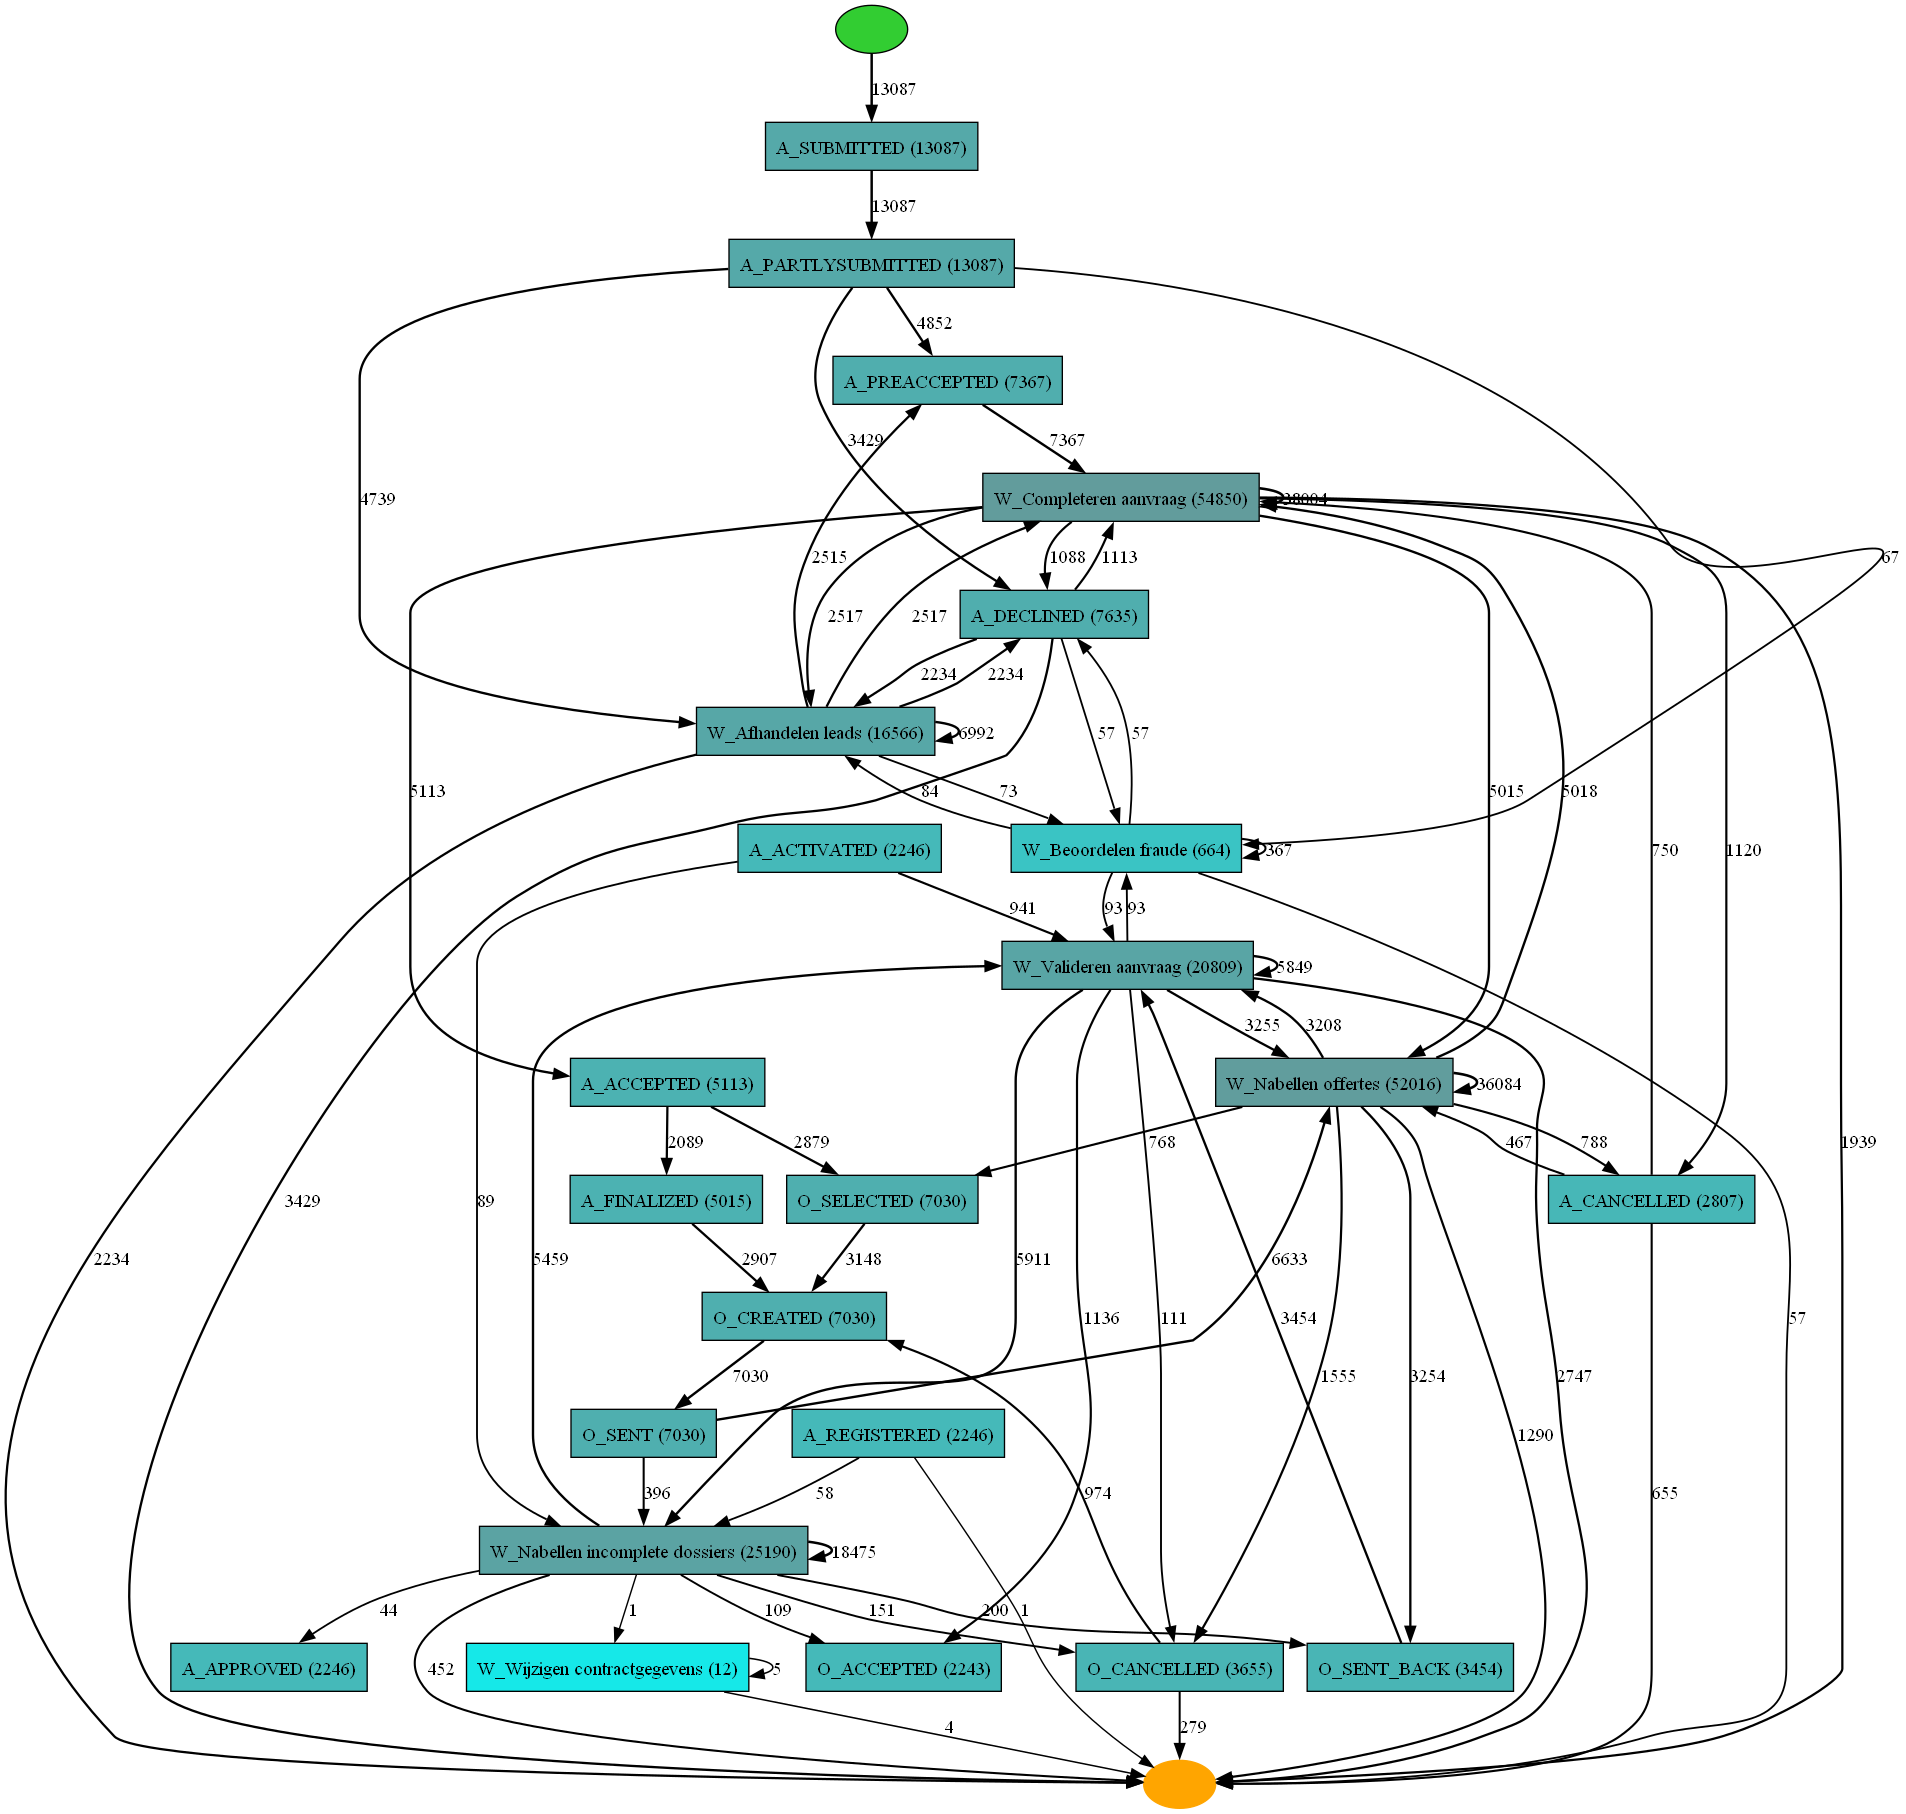

In [14]:
heu_net = heuristics_miner.apply_heu(log, parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: 0.5})
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)

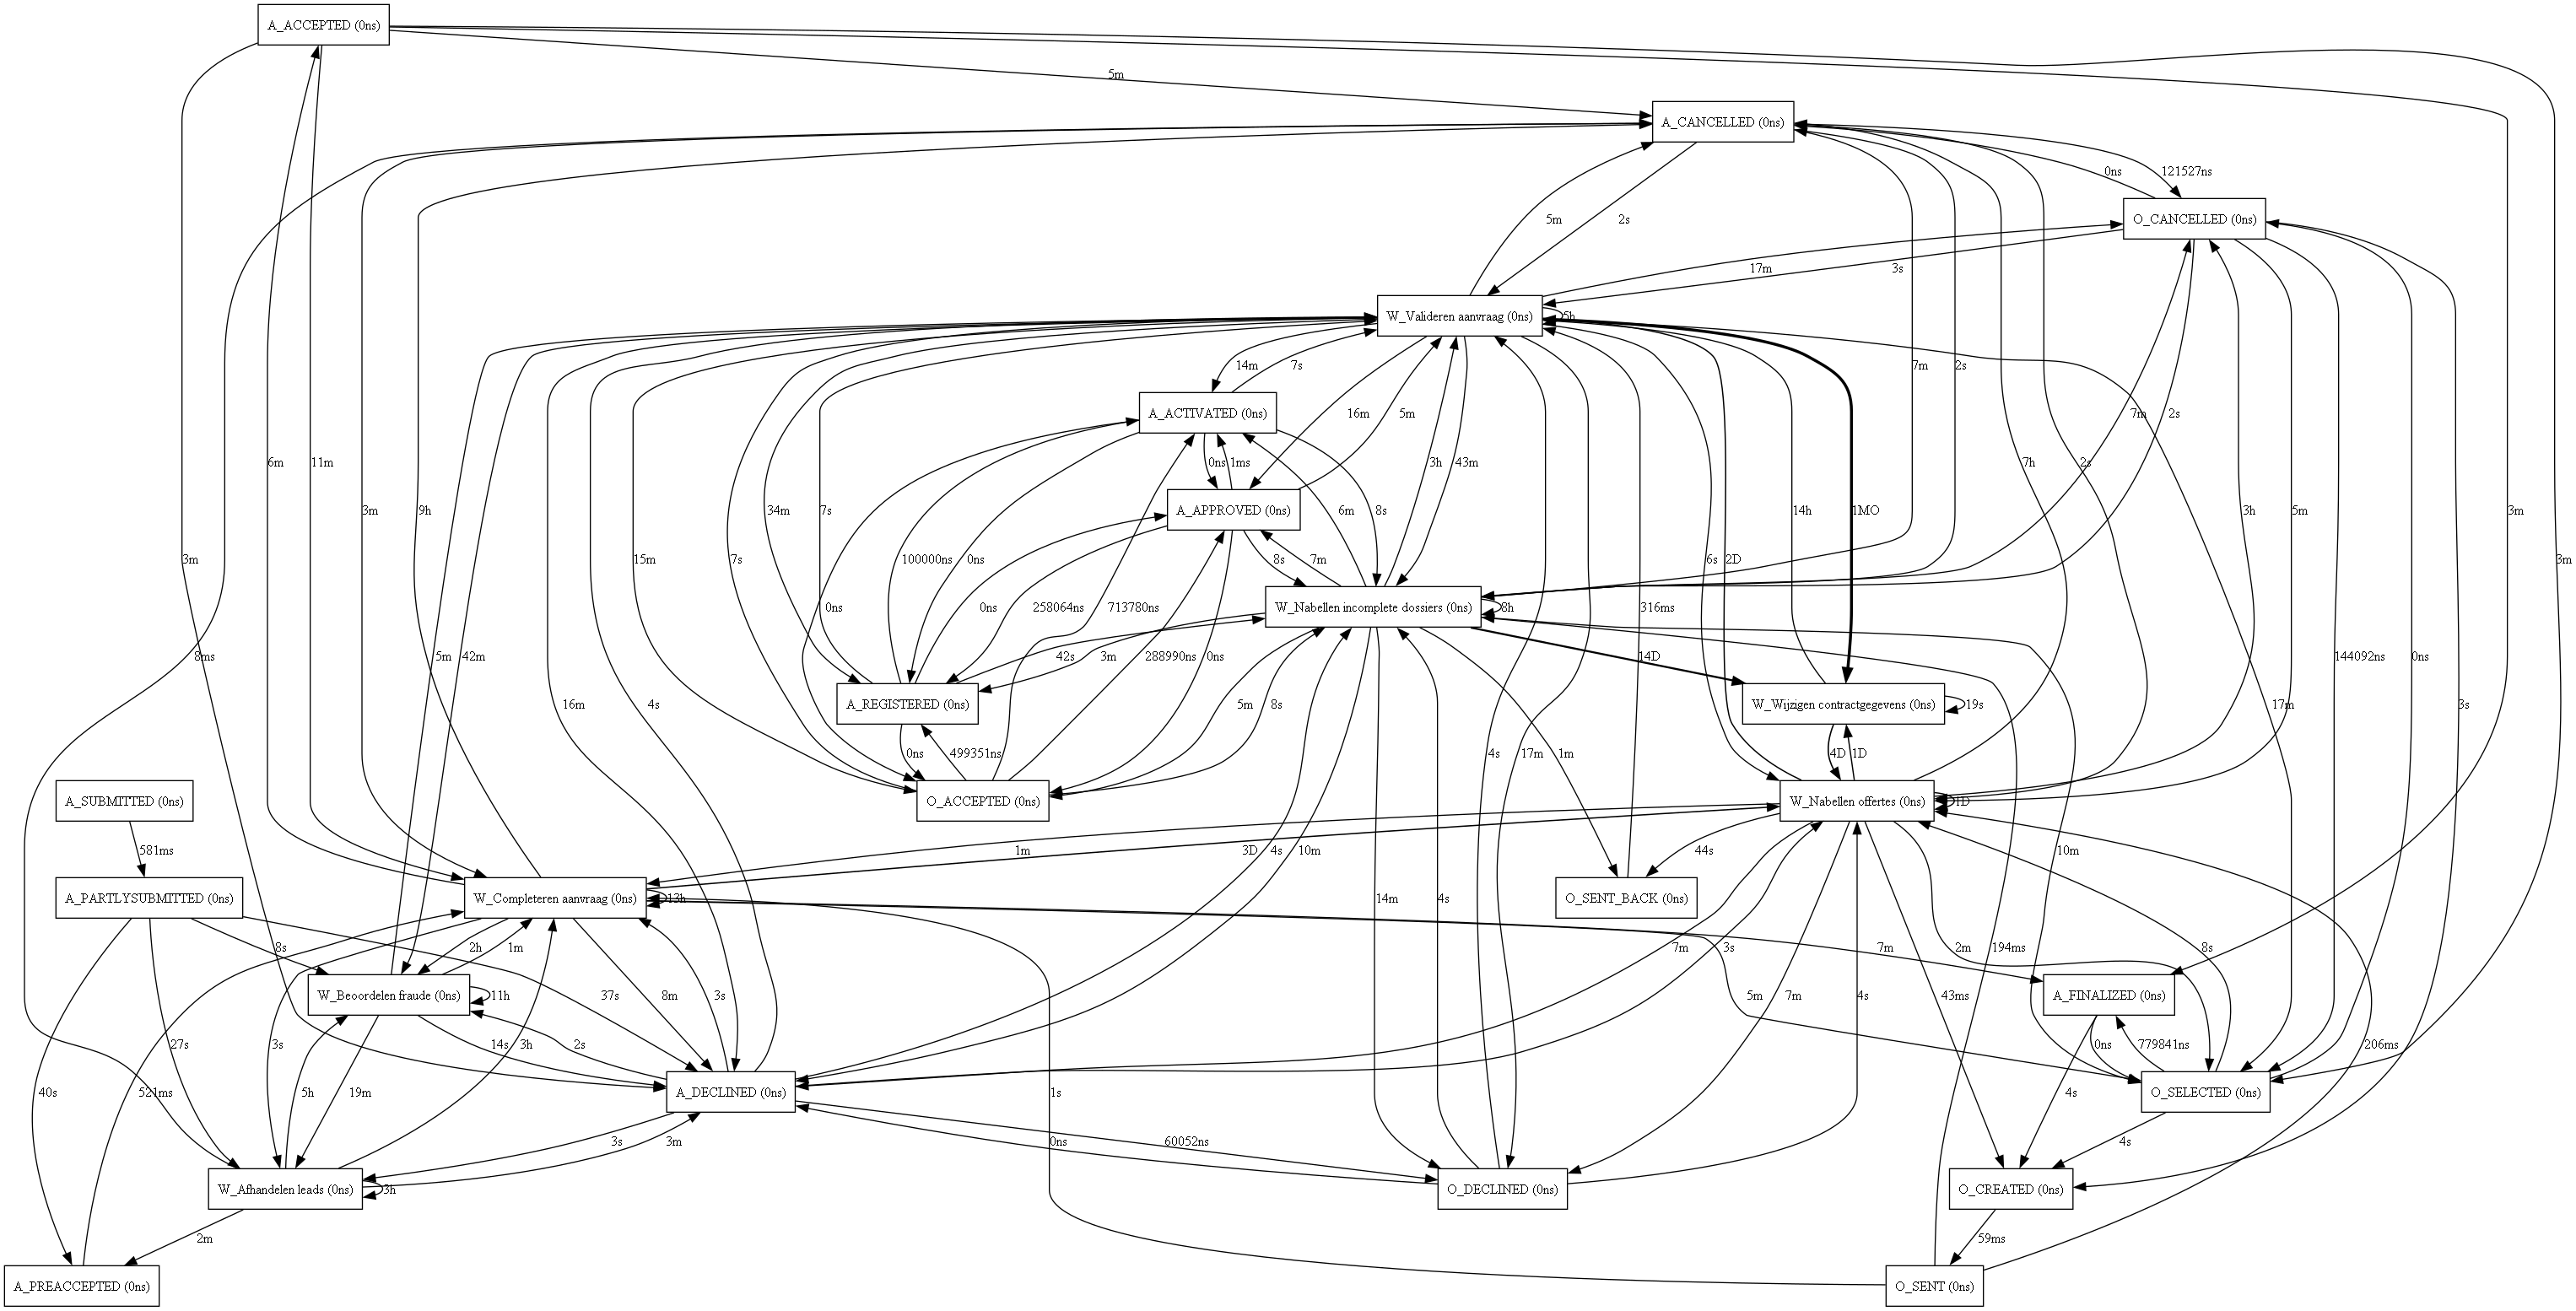

In [15]:
## Let's now take how much time it takes to travel between activities in our process

dfg = dfg_discovery.apply(log, variant=dfg_discovery.Variants.PERFORMANCE)
gviz = dfg_visualization.apply(dfg, log=log, variant=dfg_visualization.Variants.PERFORMANCE)
dfg_visualization.view(gviz)